# Yacht Hydrodynamics Prediction
Delft data set, used to predict the hydodynamic performance of sailing yachts from dimensions and velocity.

#### Data Exploration

In [1]:
import numpy as np
import torch
import os
from os import path
from sklearn.model_selection import KFold
import pandas as pd
import zipfile
import urllib.request

if not path.exists("UCI"): 
    os.mkdir("UCI")

url = "http://archive.ics.uci.edu/ml/machine-learning-databases/00243/yacht_hydrodynamics.data"
file_name = url.split('/')[-1]
if not path.exists("UCI/" + file_name):
    urllib.request.urlretrieve(url, "UCI/" + file_name)

ds = pd.read_csv('UCI/yacht_hydrodynamics.data', header=1, delimiter='\s+')
ds.describe()

,-2.3,0.568,4.78,3.99,3.17,0.150,0.27
count,306.000000,306.000000,306.000000,306.000000,306.000000,306.000000,306.000000
mean,-2.382353,0.564111,4.788693,3.936471,3.207059,0.288480,10.562712
std,1.518158,0.023364,0.253884,0.549970,0.248792,0.100532,15.187054
min,-5.000000,0.530000,4.340000,2.810000,2.730000,0.125000,0.010000
25%,-2.400000,0.546000,4.770000,3.750000,3.150000,0.200000,0.782500
50%,-2.300000,0.565000,4.780000,3.950000,3.150000,0.300000,3.090000
75%,-2.300000,0.574000,5.100000,4.170000,3.510000,0.375000,12.845000
max,0.000000,0.600000,5.140000,5.350000,3.640000,0.450000,62.420000


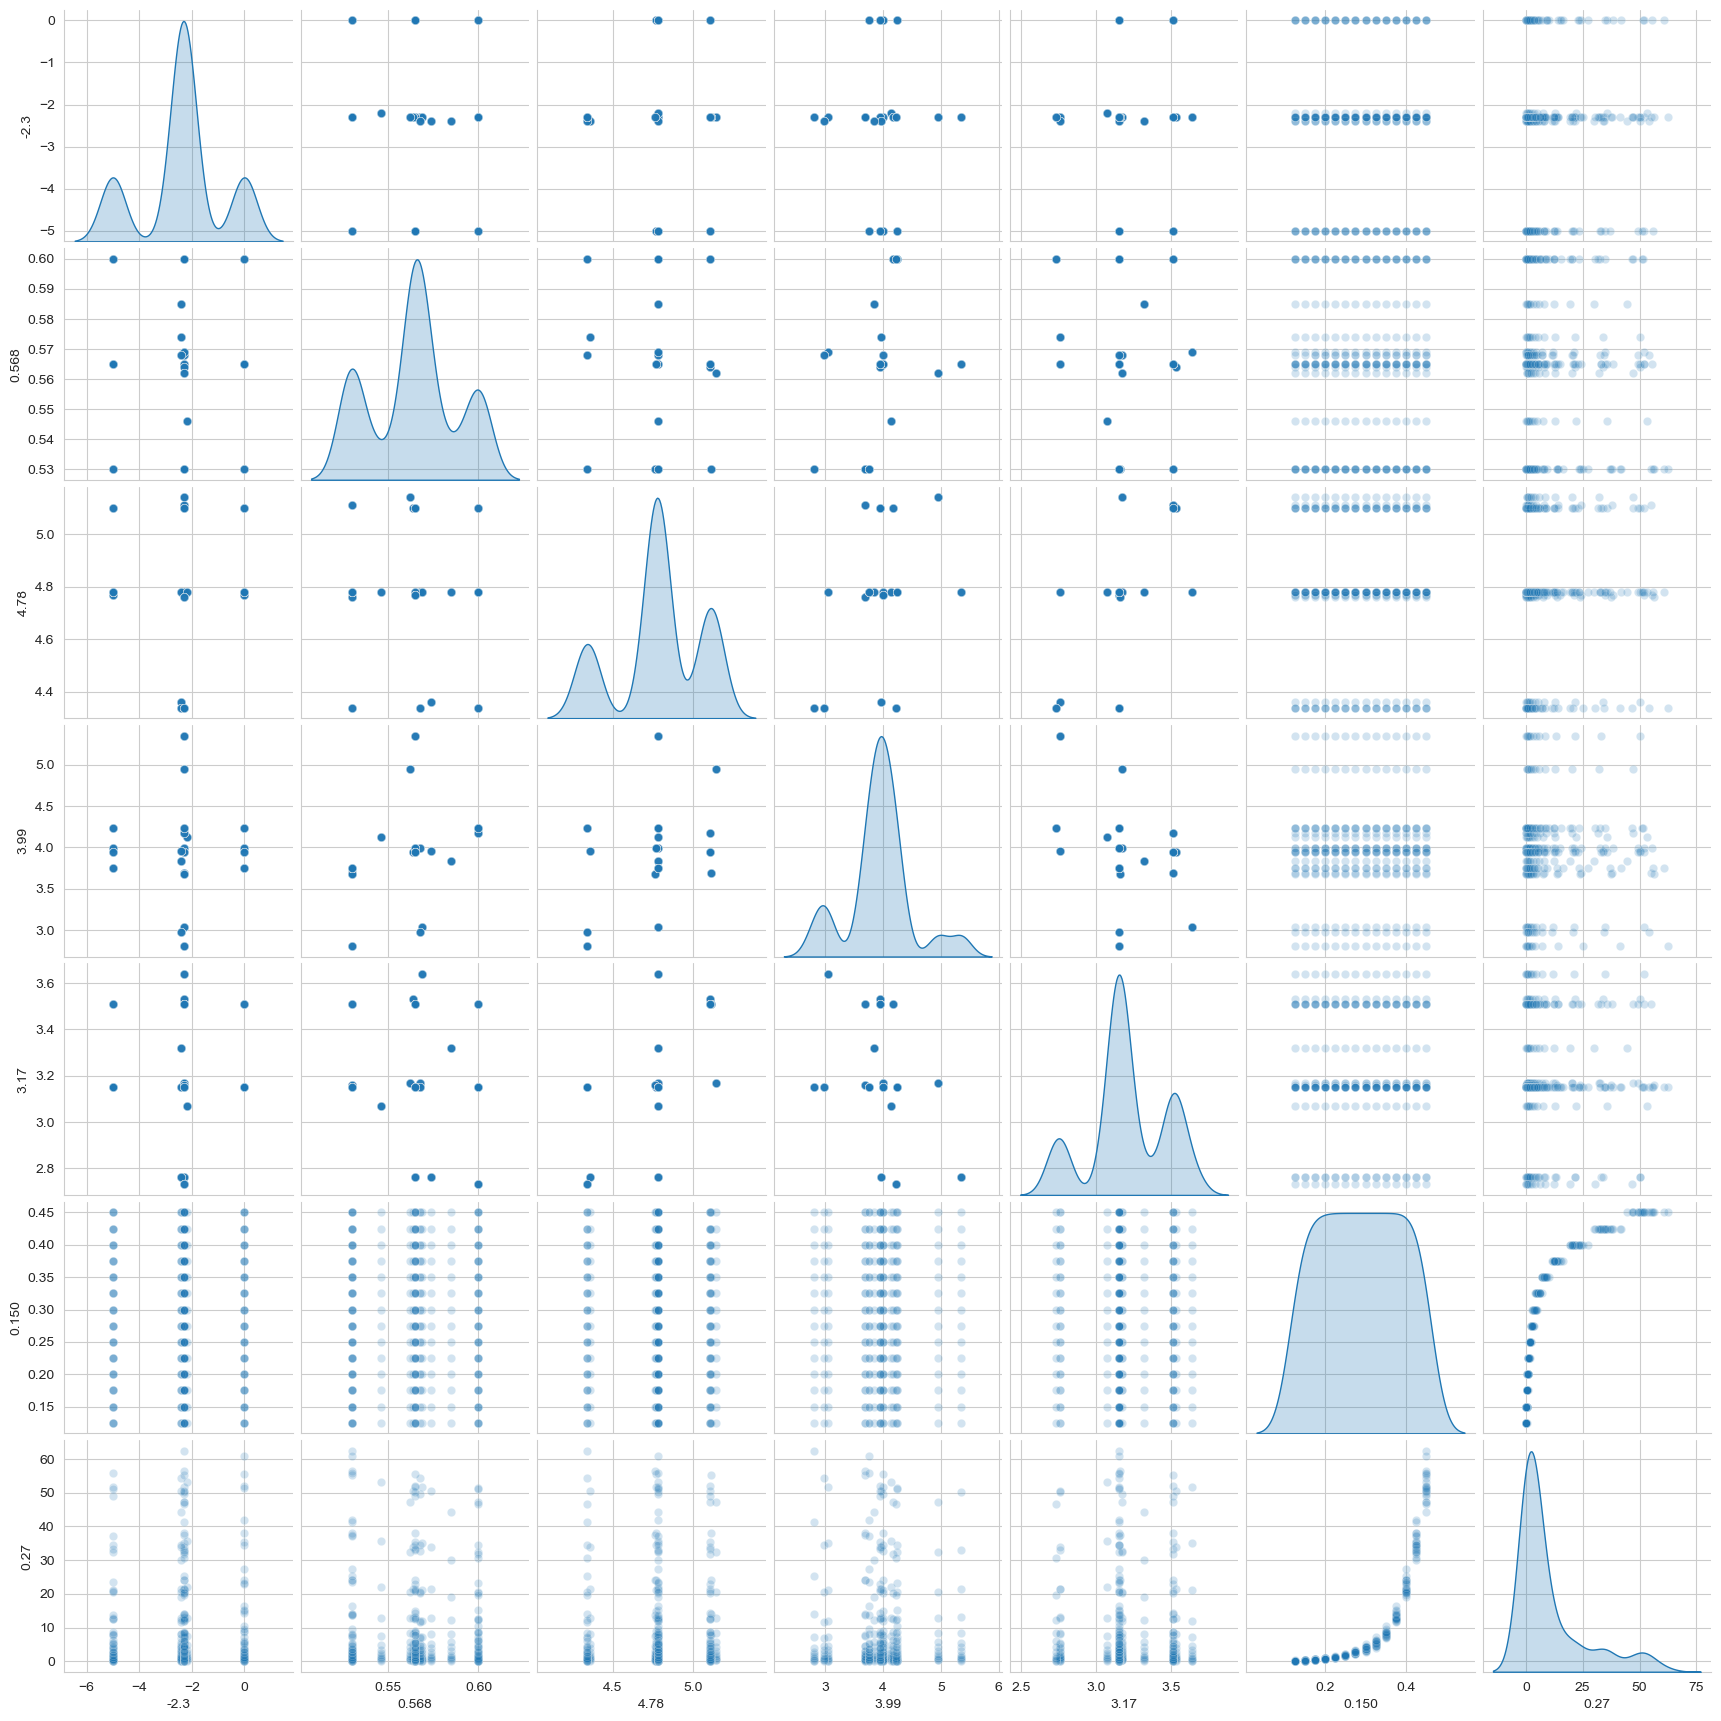

In [2]:
import seaborn as sns

sns.pairplot(ds,diag_kind='kde',plot_kws={'alpha': .2});

In [3]:
# shuffle data
data = ds.values[np.random.permutation(np.arange(len(ds.values)))]

in_dim, out_dim = data.shape[1] - 1, 1

X, y = data[:, :in_dim], data[:, in_dim:]

# normalize and center data
X_means, X_stds = X.mean(axis=0), X.std(axis=0)
y_means, y_stds = y.mean(axis=0), y.std(axis=0)
X = (X - X_means)/X_stds
y = (y - y_means)/y_stds

#### 5 Fold Cross Validation for Linear Regression

In [4]:
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
from sklearn import linear_model, tree, ensemble

kf =KFold(n_splits=5, shuffle=True, random_state=42)
# We use negative mean squared error as score because sklearn expects a score, not a loss
score = cross_val_score(linear_model.LinearRegression(), X, y, cv= kf, scoring="neg_mean_squared_error")
print(f'Scores for each fold: {-score}')

print(f'Avg MSE = {"{:.2f}".format(-score.mean())}')

Scores for each fold: [0.35466431 0.35959888 0.43871404 0.32087946 0.37571712]
Avg MSE = 0.37


#### 5 Fold Cross Validation for Decision Tree

In [5]:
score = cross_val_score(tree.DecisionTreeRegressor(random_state= 42), X, y, cv=kf, scoring="neg_mean_squared_error")

print(f'Scores for each fold: {-score}')
print(f'Avg MSE = {"{:.2f}".format(-score.mean())}')

Scores for each fold: [0.00255089 0.0099539  0.00666299 0.01114462 0.00831016]
Avg MSE = 0.01


#### 5 Fold Cross Validation for Random Forest

In [6]:
score = cross_val_score(ensemble.RandomForestRegressor(random_state= 42), X, y.ravel(), cv= kf, scoring="neg_mean_squared_error")

print(f'Scores for each fold: {-score}')
print(f'Avg MSE = {"{:.2f}".format(-score.mean())}')

Scores for each fold: [0.00177886 0.00910878 0.00323803 0.00641439 0.00477698]
Avg MSE = 0.01


#### 5 Fold Cross for Hyper param optimization of Decision Tree

In [7]:
max_depth = [1,5,10,20,50,100]

for val in max_depth:
    score = cross_val_score(tree.DecisionTreeRegressor(max_depth= val, random_state= 42), X, y, cv= kf, scoring="neg_mean_squared_error")
    print(f'For max depth: {val}')
    print(f'Avg MSE = {"{:.2f}".format(-score.mean())}')

For max depth: 1
Avg MSE = 0.22
For max depth: 5
Avg MSE = 0.01
For max depth: 10
Avg MSE = 0.01
For max depth: 20
Avg MSE = 0.01
For max depth: 50
Avg MSE = 0.01
For max depth: 100
Avg MSE = 0.01


#### 5 Fold Cross for Hyper param optimization of Random Forest

In [8]:
estimators = [10, 50, 100, 150, 200, 250, 300]

for count in estimators:
    score = cross_val_score(ensemble.RandomForestRegressor(n_estimators= count, random_state= 42), X, y.ravel(), cv= kf, scoring="neg_mean_squared_error")
    print(f'For estimators: {count}')
    print(f'Avg MSE = {"{:.2f}".format(-score.mean())}')

For estimators: 10
Avg MSE = 0.01
For estimators: 50
Avg MSE = 0.01
For estimators: 100
Avg MSE = 0.01
For estimators: 150
Avg MSE = 0.01
For estimators: 200
Avg MSE = 0.01
For estimators: 250
Avg MSE = 0.01
For estimators: 300
Avg MSE = 0.01


#### NN Regressor

In [12]:
from torch import nn

class NNRegressor(nn.Module):
    def __init__(self, layers=[20,30,20], n_features=6, activation=nn.ReLU):
        super().__init__()
        self.layers = []
        self.activation_functions = []

        self.layers.append(nn.Linear(n_features, layers[0]))
        self.activation_functions.append(activation())
        self.add_module(f"layer{0}", self.layers[-1])
        self.add_module(f"act{0}", self.activation_functions[-1])

        for i in range(1, len(layers)):
            self.layers.append(nn.Linear(self.layers[-1].out_features, layers[i]))
            self.activation_functions.append(activation())
            self.add_module(f"layer{i}", self.layers[-1])
            self.add_module(f"act{i}", self.activation_functions[-1])

        self.output = nn.Linear(self.layers[-1].out_features, 1)

    def forward(self, x):
        for layer, act in zip(self.layers, self.activation_functions):
            x=act(layer(x))

        x = self.output(x)
        return x

#### Grid search hyper param optimization for NN

In [13]:
from sklearn.model_selection import GridSearchCV
from torch import optim
from skorch import NeuralNetRegressor

param_grid = {
    'optimizer': [optim.Adam, optim.Adamax, optim.NAdam],
    'module__activation': [nn.Identity, nn.ReLU, nn.GELU, nn.Tanh, nn.Sigmoid],
    'batch_size': [10, 25, 50],
    'module__layers': [[10,20,10],[30,20,10],[30,30,30]],
    'lr': [0.0001, 0.001, 0.01],
}

grid = GridSearchCV(
    estimator = NeuralNetRegressor(module=NNRegressor),
    param_grid = param_grid,
    n_jobs = -1,
    cv = 3,
    error_score = 'raise',
    return_train_score = True,
    verbose = 0,
    scoring = 'neg_mean_squared_error'
)

In [14]:
X_tensor = torch.from_numpy(X).float()
y_tensor = torch.from_numpy(y).float()

grid.fit(X_tensor, y_tensor)

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.8190        1.1064  0.0339
      2        0.8091        1.0966  0.0091
      3        0.8003        1.0871  0.0100
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        1.0503        0.5195  0.0404
      4        0.7919        1.0778  0.0084
      5        0.7838        1.0685  0.0083
      2        1.0361        0.5105  0.0135
      6        0.7758        1.0593  0.0081
      3        1.0228        0.5018  0.0082
      7        0.7679        1.0500  0.0076
      4        1.0095        0.4931  0.0076
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.9602        1.1318  0.0337
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        1.1534        0.5194  0.0388
  epoch    train_loss    valid_loss     dur
-------  ------------  ---------

GridSearchCV(cv=3, error_score='raise',
             estimator=<class 'skorch.regressor.NeuralNetRegressor'>[uninitialized](
  module=<class '__main__.NNRegressor'>,
),
             n_jobs=-1,
             param_grid={'batch_size': [10, 25, 50],
                         'lr': [0.0001, 0.001, 0.01],
                         'module__activation': [<class 'torch.nn.modules.linear.Identity'>,
                                                <class 'torch.nn.modules.activation.ReLU'>,
                                                <class 'torch.nn.modules.activation.GELU'>,
                                                <class 'torch.nn.modules.activation.Tanh'>,
                                                <class 'torch.nn.modules.activation.Sigmoid'>],
                         'module__layers': [[10, 20, 10], [30, 20, 10],
                                            [30, 30, 30]],
                         'optimizer': [<class 'torch.optim.adam.Adam'>,
                                       <class 'torch.optim.adamax.Adamax'>,
                                       <class 'torch.optim.nadam.NAdam'>]},
             return_train_score=True, scoring='neg_mean_squared_error')

In [15]:
print("Best params:")
grid.best_params_

Best params:


{'batch_size': 10,
 'lr': 0.01,
 'module__activation': torch.nn.modules.activation.GELU,
 'module__layers': [10, 20, 10],
 'optimizer': torch.optim.adam.Adam}

In [16]:
print(f'Best MSE = {"{:.2f}".format(-grid.best_score_)}')

Best MSE = 0.02


# Results
The best model is the Random Forest with at least 10 estimators. The avarage MSE for the model is 0.01